## Installing offline deps

As this is a code comp, there is no internet. 
So we have to do some silly things to get dependencies in here. 
Why is asciitree such a PITA? 

In [1]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    NormalizeIntensityd,
)

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together. 

In [21]:
def calculate_patch_starts_minimal(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.

    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension

    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]

    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)

    if n_patches == 1:
        return [0]

    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)

    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.

    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)

    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts_minimal(m, patch_size)
    y_starts = calculate_patch_starts_minimal(n, patch_size)
    z_starts = calculate_patch_starts_minimal(l, patch_size)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

def calculate_patch_starts(dimension_size: int, patch_size: int, overlap: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with a specified overlap.

    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension
    overlap : int
        Amount of overlap between consecutive patches

    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]

    # Ensure overlap does not exceed patch size
    if overlap >= patch_size:
        raise ValueError("Overlap must be smaller than the patch size")

    # Calculate starting positions
    positions = []
    current_pos = 0
    while current_pos + patch_size <= dimension_size:
        positions.append(current_pos)
        current_pos += patch_size - overlap

    # Ensure the last patch covers the end of the dimension
    if positions[-1] + patch_size < dimension_size:
        positions.append(dimension_size - patch_size)

    return positions

def extract_3d_patches_with_overlap(arrays: List[np.ndarray], patch_size: int, overlap: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with a specified overlap.

    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)
    overlap : int
        Amount of overlap between consecutive patches

    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size, overlap)
    y_starts = calculate_patch_starts(n, patch_size, overlap)
    z_starts = calculate_patch_starts(l, patch_size, overlap)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates


# Note: I should probably averge the overlapping areas,
# but here they are just overwritten by the most recent one.

def reconstruct_array(
        patches: List[np.ndarray],
        coordinates: List[Tuple[int, int, int]],
        original_shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Reconstruct array from patches.

    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array

    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions

    patch_size = patches[0].shape[0]

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch

    return reconstructed

def reconstruct_array_with_average(
        patches: List[np.ndarray],
        coordinates: List[Tuple[int, int, int]],
        original_shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Reconstruct array from patches, averaging overlapping regions.

    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array

    Returns:
    --------
    np.ndarray
        Reconstructed array with averaged overlapping regions
    """
    reconstructed = np.zeros(original_shape, dtype=np.float64)  # To accumulate values
    weight_array = np.zeros(original_shape, dtype=np.float64)   # To count contributions

    patch_size = patches[0].shape[0]

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += patch
        weight_array[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        averaged_array = np.divide(reconstructed, weight_array, out=np.zeros_like(reconstructed), where=weight_array > 0)

    return averaged_array.astype(np.float64)

## Submission helper functions

These help with getting the submission in the correct format

In [3]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

## Reading in the data

In [4]:
TRAIN_DATA_DIR = "/home/naoya/kaggle/czii/input/numpy-dataset"
TEST_DATA_DIR = "/home/naoya/kaggle/czii/input/czii-cryo-et-object-identification/czii-cryo-et-object-identification"

In [5]:
from typing import List, Optional, Tuple, Union

import torch
import torch.nn as nn
from monai.losses import TverskyLoss, DiceFocalLoss
from monai.networks.nets import UNet

class Unet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Union[Tuple[int, ...], List[int]],
        strides: Union[Tuple[int, ...], List[int]],
        num_res_units: int,
    ):
        super().__init__()
        self.model = UNet(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=channels,
            strides=strides,
            num_res_units=num_res_units,
        )
        # self.loss_fn = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.loss_fn = 'dummy'

    def forward(
        self,
        x: torch.Tensor,
        y: Optional[torch.Tensor],
    ) -> dict[str, torch.Tensor]:

        logits = self.model(x)

        output = {"logits": logits}
        if y is not None:
            loss = self.loss_fn(logits, y)
            output["loss"] = loss

        return output

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [7]:
spatial_dims = 3
in_channels = 1
out_channels = 7
channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)       
num_res_units = 1

In [8]:
import json
copick_config_path = TRAIN_DATA_DIR + "/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '/home/naoya/kaggle/czii/input/czii-cryo-et-object-identification/train/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [9]:
import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [10]:
# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [11]:
import cc3d

id_to_name = {
    1: "apo-ferritin", 
    2: "beta-amylase",
    3: "beta-galactosidase", 
    4: "ribosome", 
    5: "thyroglobulin", 
    6: "virus-like-particle"
}

particle_radius = {
    'apo-ferritin': 60,
    'beta-amylase': 65,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [12]:
import os
import sys
sys.path.append('/home/naoya/kaggle/czii/project/A/src')

from utils.score import score

In [ ]:
PROJECT_ID = 'A'
NUM_FOLDS = 7
EXP_NO = '003'
MODEL_DIR = f'/home/naoya/kaggle/czii/project/{PROJECT_ID}/output/train/{EXP_NO}'

PATCH_SIZE = int(96 * 1.25)

# BLOB_THRESHOLD = 500 // 4

SCALE = 0.000025
CERTAINTY_THRESHOLD = 0.05

message = 'mean'


VALID_DICT = {
    'TS_5_4': 0,
    'TS_6_4': 1,
    'TS_69_2': 2,
    'TS_6_6': 3,
    'TS_73_6': 4,
    'TS_86_3': 5,
    'TS_99_9': 6,
}
VALID_IDs = ['TS_5_4', 'TS_6_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
# VALID_IDs = [ 'TS_6_4']

location_df_list = []

for VALID_ID in VALID_IDs:
    VALID_FOLD = VALID_DICT[VALID_ID]
    models = []

    cp = f"{MODEL_DIR}/{EXP_NO}-{VALID_FOLD}/single/best_model.pth"
    print(f'loading {cp}...')
    model = Unet(spatial_dims, in_channels, out_channels, channels, strides_pattern, num_res_units)
    state_dict = torch.load(cp)
    state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}

    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    models.append(model)

    classes = [1, 3, 4, 5, 6]
    with torch.no_grad():
        location_df = []
        for run in root.runs:
            print(run)
            if run.name != VALID_ID:
                continue

            tomo = run.get_voxel_spacing(10)
            tomo = tomo.get_tomogram(tomo_type).numpy()

            tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], PATCH_SIZE)
            print(tomo.shape)
            print(len(tomo_patches))

            tomo_patched_data = [{"image": img} for img in tomo_patches]

            tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

            probability = np.zeros((7, 184, 630, 630), dtype=np.float32)
            count = np.zeros((7, 184, 630, 630), dtype=np.float32)
            for i in range(len(tomo_ds)):
                input_tensor = tomo_ds[i]['image'].unsqueeze(0).to(device)
                
                avg_probs = None
                for model in models:
                    model_output = model(input_tensor, None)["logits"]
                    probs = torch.softmax(model_output[0], dim=0)
                    if avg_probs is None:
                        avg_probs = probs
                    else:
                        avg_probs += probs
                avg_probs /= len(models)

                # print(avg_probs.shape)

                (z, y, x) = coordinates[i]
                probability[
                    :,
                    z:z + PATCH_SIZE,
                    y:y + PATCH_SIZE,
                    x:x + PATCH_SIZE,
                ] = avg_probs.cpu().numpy()

                count[
                    :,
                    z:z + PATCH_SIZE,
                    y:y + PATCH_SIZE,
                    x:x + PATCH_SIZE,
                ] += 1

            probability = probability / (count + 0.0001)
            # print(probability.shape)

            arg_classes = np.argsort(probability, axis=0)
            max_classes = arg_classes[-1]
            
            # second_max_classes = arg_classes[-2]

            # # クラスのインデックスを降順にソート
            # arg_classes = np.argsort(probability, axis=0)

            # # 最大クラスの初期化（背景クラスで初期化）
            # max_classes = np.zeros_like(probability[0], dtype=int)

            # # 最大クラスの確率が閾値以上でかつ背景クラス以外のものを選択
            # for idx in range(probability.shape[0] - 1, 0, -1):  # 背景クラス（0）をスキップ
            #     class_probs = probability[idx]  # 現在のクラスの確率
            #     mask = (class_probs > CERTAINTY_THRESHOLD) & (max_classes == 0)  # 閾値と背景条件
            #     max_classes[mask] = idx  # クラスを割り当て

            # # Apply threshold
            # z, y, x = np.meshgrid(
            #     np.arange(probability.shape[1]),  # z-dimension (height)
            #     np.arange(probability.shape[2]),  # y-dimension (width)
            #     np.arange(probability.shape[3]),  # x-dimension (depth)
            #     indexing='ij'
            # )

            # Apply threshold to max_classes
            # max_classes[probability[max_classes, z, y, x] <= CERTAINTY_THRESHOLD] = 0

            # # Apply threshold to second_max_classes (if needed)
            # second_max_classes[probability[second_max_classes, z, y, x] <= CERTAINTY_THRESHOLD] = 0
            # second_max_classes[max_classes != 0] = 0
            
            location_1 = {}
            for c in classes:
                cc = cc3d.connected_components(max_classes == c)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:] * 10.012444
                zyx_large = zyx[stats['voxel_counts'][1:] > 4 * particle_radius[id_to_name[c]]**3 * np.pi * SCALE / 3]
                # zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])

                location_1[id_to_name[c]] = xyz

            # location_2 = {}
            # for c in classes:
            #     cc = cc3d.connected_components(second_max_classes == c)
            #     stats = cc3d.statistics(cc)
            #     zyx = stats['centroids'][1:] * 10.012444
            #     zyx_large = zyx[stats['voxel_counts'][1:] > 4 * particle_radius[id_to_name[c]]**3 * np.pi * SCALE / 3]
            #     # zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
            #     xyz = np.ascontiguousarray(zyx_large[:, ::-1])

            #     location_2[id_to_name[c]] = xyz

            df_1 = dict_to_df(location_1, run.name)
            # df_2 = dict_to_df(location_2, run.name)
            location_df.append(df_1)
            # location_df.append(df_2)
        
        location_df = pd.concat(location_df)
        location_df.insert(loc=0, column='id', value=np.arange(len(location_df)))
        location_df_list.append(location_df)

        submit_df = location_df
        solution_df = pd.read_csv(f'/home/naoya/kaggle/czii/input/solution/solution_{VALID_ID}.csv')
        val_lb = score(solution_df, location_df, 'row_id', 0.5, 4)
        print(val_lb)
        validation_score_path = f"{MODEL_DIR}/{EXP_NO}-{VALID_FOLD}/single/validation_score_{VALID_ID}_{PATCH_SIZE}.txt"
        if os.path.exists(validation_score_path):
            with open(validation_score_path, "a") as f:
                f.write(f"\n{message}. Appending new score.\n")
                f.write(str(val_lb))
        else:
            with open(validation_score_path, "w") as f:
                f.write(str(val_lb))

final_location_df = pd.concat(location_df_list, axis=0)
all_solution_df = pd.read_csv('/home/naoya/kaggle/czii/input/solution/solution.csv')

final_lb = score(all_solution_df, final_location_df, 'row_id', 0.5, 4)
print(final_lb)
with open(f"{MODEL_DIR}/final_score.txt", "w") as f:
    f.write(str(final_lb))

loading /home/naoya/kaggle/czii/project/A/output/train/003/003-0/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80


/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)


(184, 630, 630)
72


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 502.25it/s]


CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf0
CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f5f0
CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f320
CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c257980
CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b80
CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.6416449450317828
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-1/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c8

/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)


(184, 630, 630)
72


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 492.02it/s]
/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f320
CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c257980
CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b80
CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.7122338751728126
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-2/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80
CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf0
(184, 630, 630)
72


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 515.01it/s]


CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f5f0
CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f320
CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c257980
CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b80
CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.8083718148976181
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-3/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80
CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf

/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)


(184, 630, 630)
72


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 473.95it/s]
/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c257980
CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b80
CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.6750044621913972
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-4/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80
CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf0
CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f5f0
CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f32

Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 456.31it/s]


CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b80
CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.6894337422346304
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-5/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80
CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf0
CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f5f0
CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f320
CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c25798

/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)


(184, 630, 630)
72


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 577.35it/s]


CopickRun(name=TS_99_9, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c254530
0.6966016154222913
loading /home/naoya/kaggle/czii/project/A/output/train/003/003-6/single/best_model.pth...
CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c803c80
CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34fbf0
CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f5f0
CopickRun(name=TS_6_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c34f320
CopickRun(name=TS_73_6, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c257980
CopickRun(name=TS_86_3, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7f460c255b8

/tmp/ipykernel_483689/657772865.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)
Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 393.30

0.6997813875602025
0.70548939891348


### Iterate over test set


Below we will: 
1. Read in a run
2. Split it into patches of size (96, 96, 96)
3. Create a dataset from the patches
4. Predict the segmentation mask
5. Glue the mask back together
6. Find the connected components for each class
7. Find the centroids of the connected components
8. Add to the dataframe

Then do this for all runs. 

This can probably be optimized quite a bit. 

In [14]:
import sys
sys.path.append("/home/naoya/kaggle/czii/input/hengck-czii-cryo-et-01")

In [15]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

 TS_99_9 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  0  36    0    36   0        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  0  65    0    65   0        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  0  13    0    13   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 93
	 num hit  : 52
	 num fp   : 41
	 num miss : 6
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 88
	 num hit  : 9
	 num fp   : 79
	 num miss : 0
TS_6_4 beta-galactosidase
	 num truth   : 12
	 num predict : 99
	 num hit  : 11
	 num fp   : 88
	 num miss : 1
TS_6_4 ribosome
	 nu

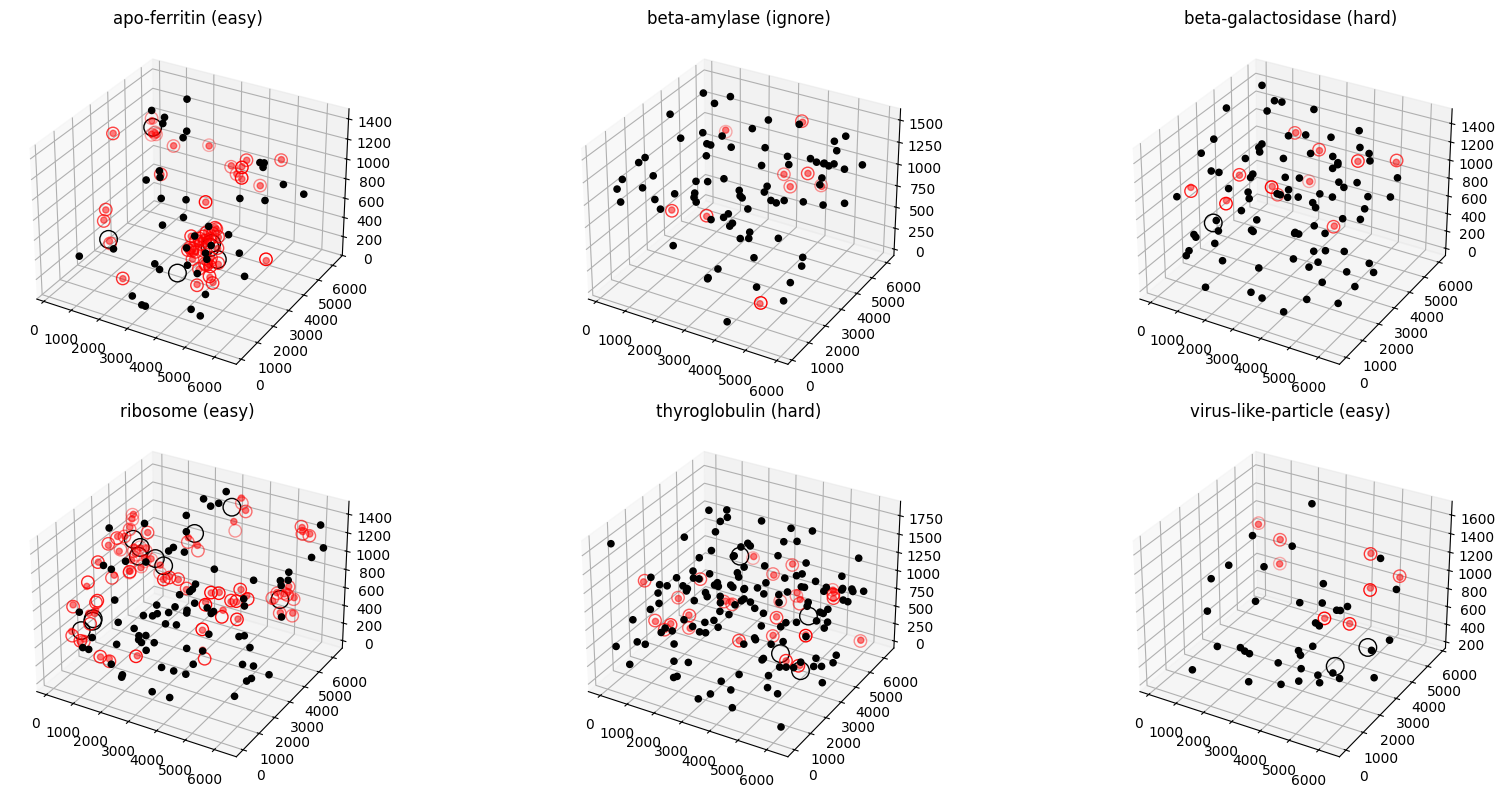

In [16]:
import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'


DEBUG = True

valid_dir ='/home/naoya/kaggle/czii/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score

def compute_lb_(submit_df, overlay_dir):
    id = VALID_ID

    eval_df = []
    
    truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
    id_df = submit_df[submit_df['experiment'] == id]
    for p in PARTICLE:
        p = dotdict(p)
        print('\r', id, p.name, end='', flush=True)
        xyz_truth = truth[p.name]
        xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
        hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
        eval_df.append(dotdict(
            id=id, particle_type=p.name,
            P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
        ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if DEBUG:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb_(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0